In [17]:
import nbformat

# Read your notebook (assuming version 4 for example purposes)
nb = nbformat.read("ml_project.ipynb", as_version=4)

# Normalize the notebook to add missing id fields and other updates
nbformat.validator.validate(nb)

# Write the normalized notebook back to a file
nbformat.write(nb, "ml_project_normalized.ipynb")

%run ml_project_normalized.ipynb

Note: you may need to restart the kernel to use updated packages.
dropped columns
cleaned intake time
cleaned intake condition
cleaned age and sex
cleaned breed
cleaned color
dropped columns


/var/folders/zg/knpz54sj16988z9vrp2b98fr0000gn/T/ipykernel_15275/3665029986.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_series = pd.to_datetime(df['intake_time'], errors='coerce')


cleaned intake time
cleaned intake condition
cleaned age and sex
cleaned breed
cleaned color
Done running ml_project.ipynb.


In [18]:
# from sklearn.decomposition import PCA

# # Apply PCA to retain 95% of variance
# pca = PCA(n_components=0.95)
# X_train = pca.fit_transform(X_train)
# X_test  = pca.transform(X_test)

# print(f"[INFO] Reduced dimensions with PCA: {X_train.shape[1]} components retained.")

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
import pandas as pd

def train_classifier(X_train, y_train, X_test, rare_classes, target_samples_per_class=3000):
  """
  Trains an Extremely Randomized Trees model using class weighting and RandomizedSearchCV.

  Parameters:
    X_train (pd.DataFrame or np.ndarray): Fully preprocessed training features.
    y_train (array-like): Encoded training labels.
    X_test (pd.DataFrame or np.ndarray): Fully preprocessed test features.
    rare_classes (list): List of int-encoded rare class labels.
    target_samples_per_class (int): Target number of samples per rare class (currently unused).

  Returns:
    best_estimator: Trained model.
    test_predictions: Predictions on the test set.
  """

  # Compute class weights for imbalanced training set
  class_labels = np.unique(y_train)
  class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)
  class_weight_dict = dict(zip(class_labels, class_weights))
  print("Class weights:", class_weight_dict)

  # Build model pipeline (only model step, encoding was done externally)
  model = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1
  )

  # Define hyperparameter search space
  param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
  }
  

  search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=5,
    cv=5,
    scoring='balanced_accuracy',
    verbose=2,
    random_state=42,
    n_jobs=2
  )

  print(f"\n[INFO] Starting training with {len(X_train)} samples")
  search.fit(X_train, y_train)
  print("[INFO] Training complete.")

  # Plotting feature importance
  import matplotlib.pyplot as plt

  feature_names = X_train.columns  # assumes X_train is still a DataFrame
  importances   = search.best_estimator_.feature_importances_
  indices       = np.argsort(importances)[::-1]

  print("\\n[INFO] Feature ranking:")
  for rank, idx in enumerate(indices[:20], 1):
    print(f"{rank}. {feature_names[idx]} — importance: {importances[idx]:.4f}")

  plt.figure(figsize=(12, 6))
  plt.title("Top 20 Feature Importances")
  plt.bar(range(20), importances[indices[:20]], align="center")
  plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

  print("Best parameters:", search.best_params_)
  print("Best CV accuracy:", search.best_score_)

  # Optionally evaluate again with cross_val_score if needed
  try:
    cv_scores = cross_val_score(
      search.best_estimator_,
      X_train,
      y_train,
      cv=5,
      scoring='balanced_accuracy',
      verbose=3
    )
    print("Generalization accuracy (via cross_val_score):", cv_scores.mean())
  except Exception as e:
    print(f"Cross-validation scoring failed: {e}")

  # Final test prediction
  test_predictions = search.best_estimator_.predict(X_test)

  return search.best_estimator_, test_predictions


Encoding mapping: ['Adoption' 'Died' 'Euthanasia' 'Return to Owner' 'Transfer']
Rare classes:
  2: Euthanasia
  1: Died
Class weights: {0: 0.40387689848121505, 1: 21.35542747358309, 2: 6.445636416352566, 3: 1.3394589383623547, 4: 0.6347361809045227}

[INFO] Starting training with 111155 samples
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END max_depth=10, min_samples_lea

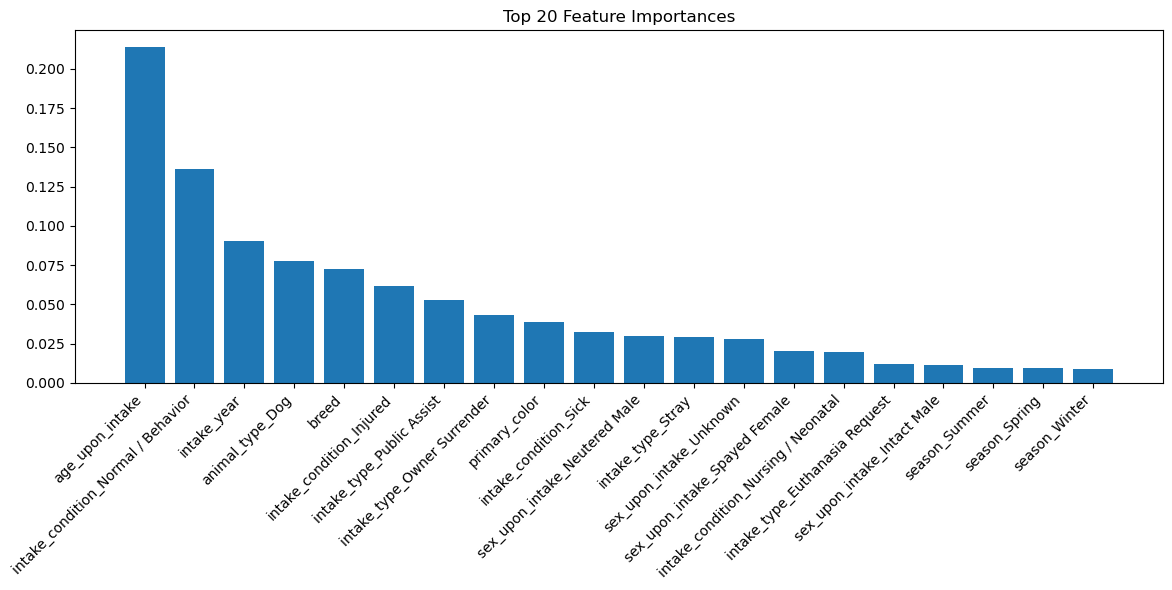

Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}
Best CV accuracy: 0.5072532290300937
[CV] END ................................ score: (test=0.502) total time=   1.3s
[CV] END ................................ score: (test=0.495) total time=   1.0s
[CV] END ................................ score: (test=0.515) total time=   1.3s
[CV] END ................................ score: (test=0.515) total time=   1.0s
[CV] END ................................ score: (test=0.509) total time=   1.0s
Generalization accuracy (via cross_val_score): 0.5072532290300937
Combined test predictions saved to: ./test_random_forest_predictions_combined.csv


In [20]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder

y_train = df_train['outcome_type']
X_test = df_test

# EXTRA DATA CLEANING
X_train = bucket_seasons(df_train)
X_test = bucket_seasons(X_test)
X_train = X_train.drop(columns=['outcome_type', 'is_mix', 'intake_hour', 'intake_month'])

# label coder will only be used for the outcome labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
print('Encoding mapping:', le.classes_)

# Define rare classes that need oversampling 
rare_classes = [
  label for label, count in pd.Series(y_train).value_counts().items()
  if count < 0.05 * len(y_train)
]
print("Rare classes:")
for cls in rare_classes:
  print(f"  {cls}: {le.classes_[cls]}")

# Define categorical features - either column names or column indices
cat_cols_onehot = ['intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake', 'season'] # TODO: should i add intake month, hour, and year here?
cat_cols_freq   = ['breed', 'primary_color']

# Frequency encode selected high-cardinality features
for col in cat_cols_freq:
  # Fit on train, apply same mapping to test
  freq_map = X_train[col].value_counts()
  X_train[col] = X_train[col].map(freq_map)
  # Unseen categories in test get frequency 0
  X_test[col]  = X_test[col].map(freq_map).fillna(0)

# One-hot encode remaining categorical features
X_train = pd.get_dummies(X_train, columns=cat_cols_onehot, drop_first=True)
X_test  = pd.get_dummies(X_test,  columns=cat_cols_onehot, drop_first=True)
# Align columns: add missing columns in X_test, fill with 0s
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Train model and get test predictions
best_model, test_predictions = train_classifier(
  X_train=X_train,
  y_train=y_train,
  X_test=X_test,
  rare_classes=rare_classes
)

# Decode integer predictions back to string labels
decoded_preds = le.inverse_transform(test_predictions)

# Save predictions using your utility function
save_predictions(decoded_preds, model_name='random_forest')